<a href="https://colab.research.google.com/github/francotestori/aauba_01/blob/fede/version_reducida.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje Automático

El objetivo de este trabajo práctico es el desarrollo de una solución que permita predecir la cancelación de una reserva utilizando como dataset el archivo provisto por la catedra ***'hotel_bookins.csv'***.

In [0]:
# Cargar el archivo original de bookings
!wget https://raw.githubusercontent.com/francotestori/aauba_01/master/resources/hotel_bookings.csv

In [0]:
from info_gain import info_gain
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date, datetime
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [0]:
pd.set_option('display.max_columns', 35)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 10000)

bookings_df = pd.read_csv('hotel_bookings.csv')

## a. División en grupos y cuantificación de categorías

---

In [14]:
columnas_categoricas = [
  'hotel', 
  'is_canceled', 
  'meal', 
  'country', 
  'market_segment', 
  'distribution_channel', 
  'is_repeated_guest', 
  'deposit_type', 
  'agent', 
  'company', 
  'customer_type', 
  'reservation_status',
  'arrival_date_month'
]
df_categoricas = bookings_df[columnas_categoricas]

columnas_numericas = [
    'lead_time',  
    'arrival_date_week_number', 
    'stays_in_weekend_nights', 
    'stays_in_weekend_nights', 
    'adults', 
    'children', 
    'babies', 
    'previous_cancellations', 
    'previous_bookings_not_canceled', 
    'booking_changes', 
    'days_in_waiting_list', 
    'adr', 
    'required_car_parking_spaces', 
    'total_of_special_requests'                      
]
df_numericas = bookings_df[columnas_numericas]

columnas_ordinales = [
       'reserved_room_type', 
       'assigned_room_type'               
]
df_ordinales = bookings_df[columnas_ordinales]
df_ordinales

def get_month_number(month):
  if month == "January":
    return 1
  elif month == "February":
    return 2   
  elif month == "March":
    return 3   
  elif month == "April":
    return 4   
  elif month == "May":
    return 5   
  elif month == "June":
    return 6   
  elif month == "July":
    return 7   
  elif month == "August":
    return 8   
  elif month == "September":
    return 9   
  elif month == "October":
    return 10
  elif month == "November":
    return 11   
  elif month == "December":
    return 12
  else:
    return 0     

def checkin(year, month_str, day):
  month = get_month_number(month_str)
  return date(year, month, day)

columnas_fecha_hora = [
  'arrival_date_month', 
  'arrival_date_year',
  'arrival_date_day_of_month',   
  'reservation_status_date'               
]
df_fecha_hora = bookings_df[columnas_fecha_hora]
df_fecha_hora['checkin_date'] = df_fecha_hora.apply(
    lambda x: checkin(x['arrival_date_year'], x['arrival_date_month'], x['arrival_date_day_of_month']),
    axis=1
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## b. Valores faltantes

In [0]:
# Haciendo un análisis simple identificamos los valores nulos ya establecidos en el dataframe
null_series = bookings_df.isnull().sum()

# Haciendo un análisis inicial contamos con faltantes en los siguientes atributos:
# * **children**: Son muy pocos casos, 4. 
# * **country**: Pocos casos sería posible con alguna medida de cercanía.
# * **agent**: Relativamente grande número de faltantes, 15%.
# * **company**: Número demasiado grande de faltantes, aprox 90%.

# Sin embargo, conocemos que hay otros campos que podrian poseer valores que analogamente representan un valor nulo. Por lo que para esos imputaremos las modas

# Relleno por el valor mas frecuente (moda)
bookings_df['meal'].fillna("BB", inplace = True)
bookings_df['children'].fillna(0.0, inplace = True)
bookings_df['market_segment'].fillna('Online TA', inplace = True)
bookings_df['distribution_channel'].fillna('TA/TO', inplace = True)

# Asigno un desconocido
bookings_df['country'].fillna('XXX', inplace = True)

# Utilizo un valor dummy (máscara) para la presencia de agent y company
bookings_df['agent'] = bookings_df['agent'].isnull()
bookings_df['company'] = bookings_df['company'].isnull()

## c. Análisis de duplicados

Vamos a analizar si hay reservas duplicadas en nuestro dataframe

In [0]:
duplicated = bookings_df[bookings_df.duplicated()]

# Analizamos el porcentaje de duplicados en base a nuestra muestra
duplicated_ratio = len(duplicated)/len(bookings_df)

# Por elementos **duplicados** entendemos que todas las features de dos filas son identicos.

# Entonces sospechabamos que podría haber casos de una misma reserva que se referenciaba 2 o mas veces en nuestro dataframe.

# Sin embargo y evaluando el peso de los duplicados en nuestro dataframe (26%), entendemos simplemente que son reservas distintas pero con las mismas características.

## c. Variables correlacionadas


In [17]:
corr = bookings_df.corr()

# Las cuatro variables más correlacionadas son:

# * **lead_time**                      0.293123
# * **total_of_special_requests**      0.234658
# * **required_car_parking_spaces**    0.195498
# * **booking_changes**                0.144381

# PUNTO DE DUDA: CÓMO ELEGIMOS LAS CUATRO MÁS CORRELACIONADAS

# Más allá de la forma, transformamos las variables para que quede un dataset con todas variables en números

# FUNCIONES AUXILIARES
def quantify_room_type(room_type):
    if room_type == 'A':
        return 1
    elif room_type == 'B':
        return 2
    elif room_type == 'C':
        return 3
    elif room_type == 'D':
        return 4
    elif room_type == 'E':
        return 5
    elif room_type == 'F':
        return 6
    elif room_type == 'G':
        return 7
    elif room_type == 'H':
        return 8
    elif room_type == 'I':
        return 9
    elif room_type == 'K':
        return 10
    elif room_type == 'L':
        return 11
    elif room_type == 'P':
        return 12
    else:
        return 0

def room_matches(this_room, other_room):
  match = this_room.lower().replace('s/+',"") == other_room.lower().replace('s/+',"")
  if(match):
    return 1
  else:
    return 0

# CATEGÓRICAS
columnas_categoricas = [
  'hotel', 
  'is_canceled', 
  'meal', 
  'country', 
  'market_segment', 
  'distribution_channel', 
  'is_repeated_guest', 
  'deposit_type', 
  'agent', 
  'company', 
  'customer_type', 
  'reservation_status',
  'arrival_date_month'
]
df_categoricas = bookings_df[columnas_categoricas]

min_dummy = len(df_categoricas)*0.005  # Mínimo de frecuencia para incluir la columna: 0.5% del total
df_categoricas['has_agent'] = bookings_df['agent'].isnull().astype(int)
df_categoricas['has_company'] = bookings_df['company'].isnull().astype(int)
dummies_cat = pd.get_dummies(
    df_categoricas, 
    columns=[
      'hotel',       
      'market_segment', 
      'meal', 
      'is_repeated_guest', 
      'deposit_type', 
      'customer_type' 
    ], 
    drop_first=False
)
dummies_cat = dummies_cat.iloc[:, 8:]
corr_cat = dummies_cat[dummies_cat.columns[dummies_cat.sum()>min_dummy]]

# ORDINALES
columnas_ordinales = [
       'reserved_room_type', 
       'assigned_room_type'               
]
df_ordinales = bookings_df[columnas_ordinales]
df_ordinales['assigned_room_vl'] = df_ordinales.apply(lambda x: quantify_room_type(x['assigned_room_type']), axis=1)
df_ordinales['requested_room_vl'] = df_ordinales.apply(lambda x: quantify_room_type(x['reserved_room_type']), axis=1)
df_ordinales['did_room_match'] = df_ordinales.apply(lambda x: room_matches(x['reserved_room_type'],x['assigned_room_type']), axis=1)
df_ordinales['booker_room_gain'] = df_ordinales.apply(lambda x: x['assigned_room_vl'] - x['requested_room_vl'], axis=1)
corr_ord = df_ordinales[['assigned_room_vl', 'requested_room_vl','did_room_match', 'booker_room_gain']]

# NUMERICAS
columnas_numericas = [
    'lead_time',  
    'arrival_date_week_number', 
    'stays_in_weekend_nights', 
    'stays_in_weekend_nights', 
    'adults', 
    'children', 
    'babies', 
    'previous_cancellations', 
    'previous_bookings_not_canceled', 
    'booking_changes', 
    'days_in_waiting_list', 
    'adr', 
    'required_car_parking_spaces', 
    'total_of_special_requests'                      
]
df_numericas = bookings_df[columnas_numericas]

corr_num = df_numericas

# UNION
df_correlations = pd.concat([corr_num,corr_ord,corr_cat],axis=1) # EN CUALQUIER CASO HAY QUE TERMINAR CON ESTE DATASET DF_CORRELATIONS QUE UNA TODO CON TODO
df_correlations.loc[:,'is_canceled'] = df_categoricas['is_canceled'] 
corr = df_correlations[df_correlations.columns].corr()['is_canceled'][:-1] 

# RESTARÍA DEFINIR CÓMO ELEGIMOS LAS CUATRO MÁS CORRELACIONADAS, QUE SERÁ EN FUNCIÓN DE LO QUE DEFINIMOS PARA LAS CORRELACIONES

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

## e. Se encuentra balanceado el set

In [18]:
# Buscamos conocer que tan balanceado está nuestro dataset
bookings_df['is_canceled'].value_counts(normalize=True)

0    0.629584
1    0.370416
Name: is_canceled, dtype: float64

## g. Implementación Árbol de decisión

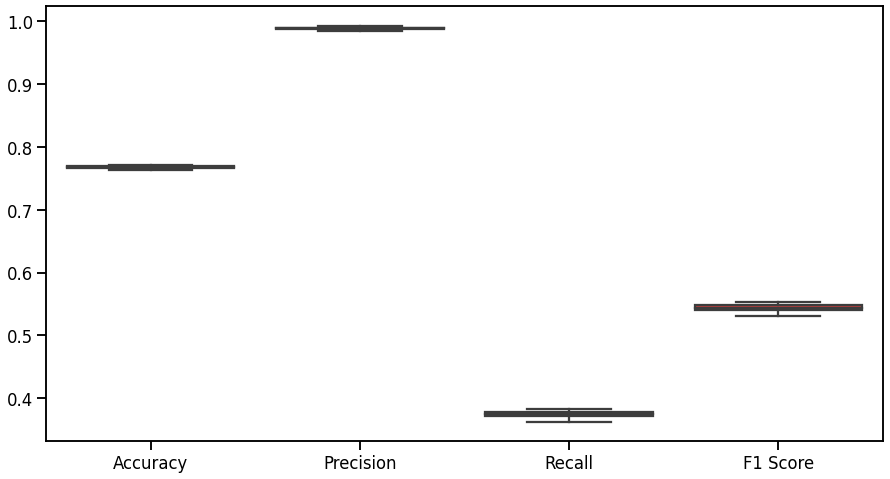

In [19]:
#Con sklearn podemos dividir nuestros datos en conjuntos de entrenamiento, validación y prueba.
# Para el análisis deberiamos utilizar un DF con las variables dummies cargadas
# Lo unico que tengo dudas es si en features no hay que dropear la columna 'is_canceled'
features =  df_correlations.loc[:, df_correlations.columns != 'is_canceled'].columns
target = 'is_canceled'

# Armamos 2 sets de datos
x_train, x_test, y_train, y_test = train_test_split(
    df_correlations[features].values, 
    df_correlations[target].values, 
    test_size=0.2, 
    random_state=42
)                           # DIVIDO ENTRE TRAIN (0.8) Y TEST (0.2)

x_val, x_test, y_val, y_test = train_test_split(
    x_test,
    y_test,
    test_size=0.2
)                           # DIVIDO ENTRE TRAIN (0.8), TEST (0.04), Y VAL (0.16)

n_seeds = 50
accs = []
precisions = []
recalls = []
f1s = []

for seed in range(n_seeds):
  # Arbol de decisión
  arbol_sklearn = DecisionTreeClassifier(
      criterion='entropy',
      max_depth=5,
      min_samples_leaf=10, 
      ccp_alpha=0.01
  )
  # División train-validation (requiere x_train y y_train previos)
  x_train_, x_val_, y_train_, y_val_ = train_test_split(
      x_train, 
      y_train, 
      test_size=0.2, 
      random_state=seed,
      stratify=y_train
  )                                           # DIVIDO ENTRE TRAIN-train_ (0.64), TRAIN-val_ (0.16), TEST (0.04), Y VAL (0.16)

  # Entrenamos al arbol
  arbol_sklearn.fit(x_train_,y_train_)

  # Ejecutamos nuestra predicción
  y_pred_val = arbol_sklearn.predict(x_val_)

  # Medimos (accuracy, precision, recall y f1Score) de nuestra predicción
  accs.append(accuracy_score(y_val_,y_pred_val))
  precisions.append(precision_score(y_val_,y_pred_val))
  recalls.append(recall_score(y_val_,y_pred_val))
  f1s.append(f1_score(y_val_,y_pred_val))

all_metrics = accs + precisions + recalls + f1s
metric_labels = ['Accuracy']*len(accs) + ['Precision']*len(precisions) + ['Recall']*len(recalls) + ['F1 Score']*len(f1s)

sns.set_context('talk')
plt.figure(figsize=(15,8))
sns.boxplot(metric_labels,all_metrics)

In [0]:
# GRÁFICA DEL ÁRBOL
plt.figure(figsize=(20,10))
plot_tree(arbol_sklearn,filled=True);